# Estimation of internal nodes and phylogenetic mean from shape observations

In the previous notebook, we learned how to define a mean estimation operation and execute it on the tree using _Hyperiax_. However, the data stored in the nodes is rather simple: 2D vectors. In practice, we have to deal with more complex data with higher dimensions. Fortunately, _Hyperiax_ can help. This time, we still aim to estimate the inner nodes and mean of a phylogenetic tree with only given leaf node values, but the data is the butterfly **shape**, characterized by discrete **landmarks**. In our case, outlines discretized by landmarks describe the wing morphology of certain butterfly species. The inner nodes thus represent wing shapes of ancestral butterfly species.

As in `mean_estimation.ipynb` we use a simple, recursive estimator for the inner nodes; any inner node will be estimated as a weighted mean of its children. Due to the _non-linear_ nature of shapes, we cannot use the ordinary **Euclidean** weighted mean. Luckily, the Python library _JAXGeometry_ is built for handling such data, including computing weighted means of shape observations. We shall use it's function to define the `fuse` we need in the upward passing.


__Content of the notebook__

* Load a dataset of shapes of 4 butterfly species and an associated evolutionary tree (phylogeny) 

* Estimate and plot the inner nodes, i.e. the estimated shapes of ancestral butterfly species. 

In [1]:
from hyperiax.tree import HypTree
from hyperiax.tree.topology import read_topology
from hyperiax.plotting import plot_tree

import jax
import jax.numpy as jnp
import pandas as pd
import requests
import matplotlib.pyplot as plt
from PIL import Image

## Load the example data

The example data is `4` observations of butterfly wings, also described in Baker et. al. 2024, https://doi.org/10.48550/arXiv.2402.01434. We represent each wing by `25` landmarks. We also load a phylogeny for these 4 species, i.e. a tree with 4 leaf nodes. All the data can be accessed under https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/.

In [2]:
# Load all files
tree_string = requests.get("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/tree.txt").text
tree = read_topology(tree_string)
landmark = pd.read_csv(
    "https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/landmarks.csv", 
    sep=",", 
    header=None)

((Graphium_evemon:0.06883,Graphium_sarpedon:0.06835)QS1810:0.13941,(Atrophaneura_dixoni:0.0434,Pachliopta_aristolochiae:0.05484)QS1845:0.16755)QS1804:0;



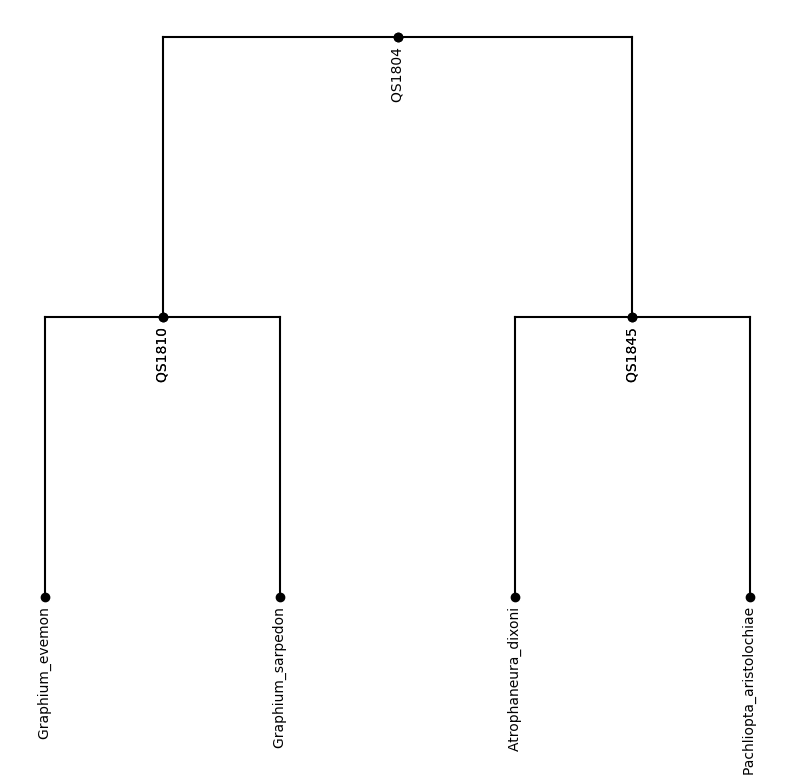

In [3]:
plot_tree(tree,inc_names=True)
print(tree_string)

In [4]:
# The name of the landmarks are placed in the tree, alongside with the edge length 
lm_dim = jnp.shape(landmark)[1]
print(f"The dimension of the landmarks is {lm_dim}")
tree.add_property('value', shape=(lm_dim, ))
# add landmarks
landmark_array = landmark.to_numpy()
reshaped_array = landmark_array.reshape(landmark_array.shape[0], landmark_array.shape[1])
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(reshaped_array)

The dimension of the landmarks is 200


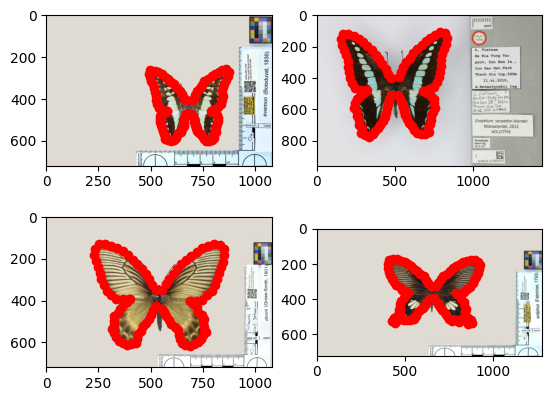

In [5]:
# visualization of landmarks 
main_path = "https://github.com/MichaelSev/Hyperiax_data/raw/main/image/"

list_of_names =["img0.jpg","img1.jpg","img2.jpg","img3.jpg"]
for i,data in enumerate(tree.data['value'][tree.is_leaf]):
    plt.subplot(2,2,i+1)
    im = Image.open(requests.get(main_path+list_of_names[i], stream=True).raw)
    implot = plt.imshow(im)
    plt.scatter(data[::2],data[1::2],c="r")
    #plt.title(str(leaf.name))

## Prepare tree for computing

As we introduced in the previous notebook, when the number of child nodes is fixed, _Hyperiax_ provides a faster way to pre-compute the gathering of children by specifying `precompute_child_gathers=True` in the initialization of a `HypTree`, and our studied case fits this requirement. Thus, we can create a copy of the tree we just loaded with pre-computed children for faster execution.

Unlike the Brownian motion, the nonlinear dynamic we use here will have a parameter `sigma`, which we need to specify. In practice, this parameter is unknown and needs to be inferred, but right now, let's just fix it for simplicity. We recommend literatures about _Large Deformation Diffeomorphic Metric Mapping (LDDMM)_ for further illustrations on the nonlinear dynamics and the significance of `sigma`.

In [6]:
# run the following code to install JAXGeometry if needed
# %pip install jaxdifferentialgeometry

In [7]:
from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambda

# Requires Jaxdifferentalgeometry package
from jaxgeometry.manifolds.landmarks import *   
from jaxgeometry.Riemannian import metric
from jaxgeometry.dynamics import Hamiltonian
from jaxgeometry.Riemannian import Log

In [8]:
topology = read_topology(tree_string, return_topology=True)
pre_tree = HypTree(topology, precompute_child_gathers=True)
pre_tree.data = tree.data.copy()

In [9]:
# Saved parameters within the tree 
pre_tree.add_property('sigma', shape=(1,))

# Fixed sigma for simplification
pre_tree.data['sigma'] = pre_tree.data['sigma'].at[:].set(0.5)

## Estimate inner nodes (i.e. ancestral shapes)

After everything is set, we can now estimate the inner nodes of the tree, i.e. the wing shapes of ancestral species, which corresponds to the **upward passing** introduced in the previous notebook. For this, we need to define a `fuse` function, which computes a non-linear version of a weighted mean: each inner node is a non-linear weighted mean of its children nodes. The particular non-linear weighted mean we compute is based on the LDDMM framework, as implemented in the JAXGeometry library.

Note this is a quicker version of the code, since we exclude the contrast and lift function for the tangent space

In [10]:
def fuse_lddmm(child_value, child_sigma, child_edge_length, **kwargs):
    def lddmm(child_coords1, child_coords2, kernel_sigma, parent_index):
        # Estimate the average distance between each landmark,
        # predefined kernel size 
        M = landmarks(jnp.shape(child_coords1)[0] // 2, k_sigma=kernel_sigma * jnp.eye(2))
        # Riemannian structure

        metric.initialize(M)
        q = M.coords(jnp.array(child_coords1))
        v = (jnp.array(child_coords2), [0])
        Hamiltonian.initialize(M)
        # Logarithm map
        Log.initialize(M, f=M.Exp_Hamiltonian)

        # Estimate momentum 
        p = M.Log(q, v)[0]

        # Hamiltonian 
        (_, qps, charts_qp) = M.Hamiltonian_dynamics(q, p, dts(n_steps=100))

        # Return landmarks, contrast and phi
        return qps[parent_index, 0, :]

    # Map function, to determine the shortest branch from child to parent 
    def map_function(child_coords_pair, child_edge_length_pair, kernel_sigma_pair):
        edge_length_sum = child_edge_length_pair.sum()

        def true_fun(_):
            parent_index = jnp.floor(child_edge_length_pair[0] / edge_length_sum * 100 - 1).astype(int)[0]
            return lddmm(child_coords_pair[0, :], child_coords_pair[1, :], kernel_sigma_pair[:, 0], parent_index)

        def false_fun(_):
            parent_index = jnp.floor(child_edge_length_pair[1] / edge_length_sum * 100 - 1).astype(int)[0]
            return lddmm(child_coords_pair[1, :], child_coords_pair[0, :], kernel_sigma_pair[:, 0], parent_index)

        # Run Upwards LDDMM; from either left or right 
     
        return jax.lax.cond((child_edge_length_pair[0] < child_edge_length_pair[1])[0], true_fun, false_fun, operand=None)

    # vmap to iterate over set of children
    qps = jax.vmap(map_function, in_axes=(0, 0, 0))(child_value, child_edge_length, child_sigma)
    
    return {'value': qps}

Now we use `UpLambda()` to wrap the `fuse` function and throw it to `OrderedExecutor`, then simply just call `.up()`.

In [11]:
upmodel = UpLambda(up_fn=fuse_lddmm)
upmodelexe = OrderedExecutor(upmodel)
res = upmodelexe.up(pre_tree)

**Visualize the results**

We can now plot one of the estimated inner nodes, computed as the weighted mean of two neighboring leaf-node shapes. The two leaf shapes are represented by the **red** and **green** points, the estimated inner node is represented by the **blue** points.

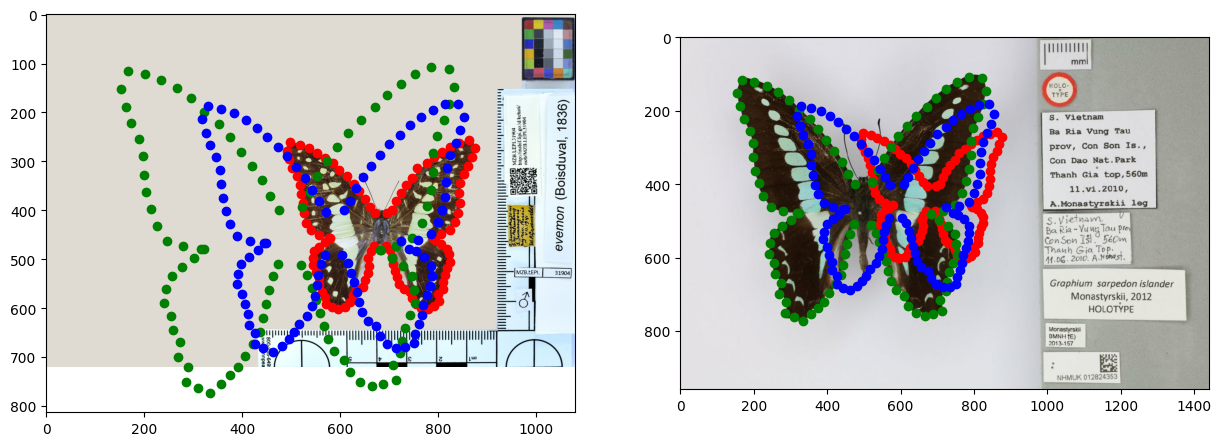

In [12]:
# Illustrate the results
plt.subplot(1, 2, 1)
# Load image 
im = Image.open(requests.get(main_path + "img0.jpg", stream=True).raw)
implot = plt.imshow(im)

# Plot points
plt.scatter(pre_tree.data['value'][3][::2], pre_tree.data['value'][3][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][4][::2], pre_tree.data['value'][4][1::2], color='green')  # child2 of root
plt.scatter(pre_tree.data['value'][1][::2], pre_tree.data['value'][1][1::2], color='blue')   # root

plt.subplot(1, 2, 2)
# Load image
im = Image.open(requests.get(main_path + "img1.jpg", stream=True).raw)
implot = plt.imshow(im)
# Plot points
plt.scatter(pre_tree.data['value'][3][::2], pre_tree.data['value'][3][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][4][::2], pre_tree.data['value'][4][1::2], color='green')  # child2 of root
plt.scatter(pre_tree.data['value'][1][::2], pre_tree.data['value'][1][1::2], color='blue')   # root
plt.show()

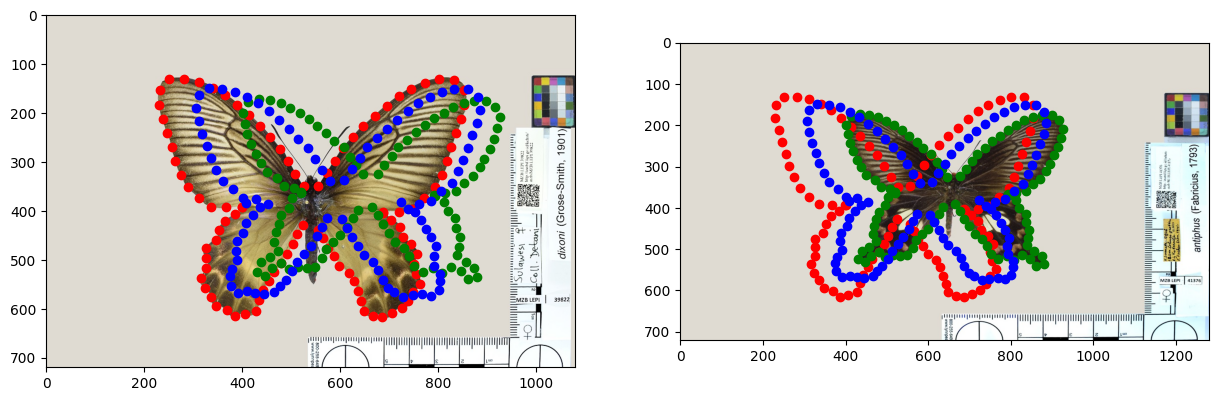

In [13]:
# Illustrate the results
plt.subplot(1, 2, 1)
# Load image 
im = Image.open(requests.get(main_path + "img2.jpg", stream=True).raw)
implot = plt.imshow(im)
# Plot points
plt.scatter(pre_tree.data['value'][5][::2], pre_tree.data['value'][5][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][6][::2], pre_tree.data['value'][6][1::2], color='green')  # child2 of root
plt.scatter(pre_tree.data['value'][2][::2], pre_tree.data['value'][2][1::2], color='blue')   # root

plt.subplot(1, 2, 2)
# Load image
im = Image.open(requests.get(main_path + "img3.jpg", stream=True).raw)
implot = plt.imshow(im)
# Plot points
plt.scatter(pre_tree.data['value'][5][::2], pre_tree.data['value'][5][1::2], color='red')    # child1 of root
plt.scatter(pre_tree.data['value'][6][::2], pre_tree.data['value'][6][1::2], color='green')  # child2 of root
plt.scatter(pre_tree.data['value'][2][::2], pre_tree.data['value'][2][1::2], color='blue')   # root
plt.show()

The points on the left and right figures are identical, the only difference is the superimposed image.

Next, we plot all leaf nodes (points in **orange** colors), the estimated inner node shape (**blue** points), and the root node shape (**red** points), i.e. the common ancestor of all 4 species.

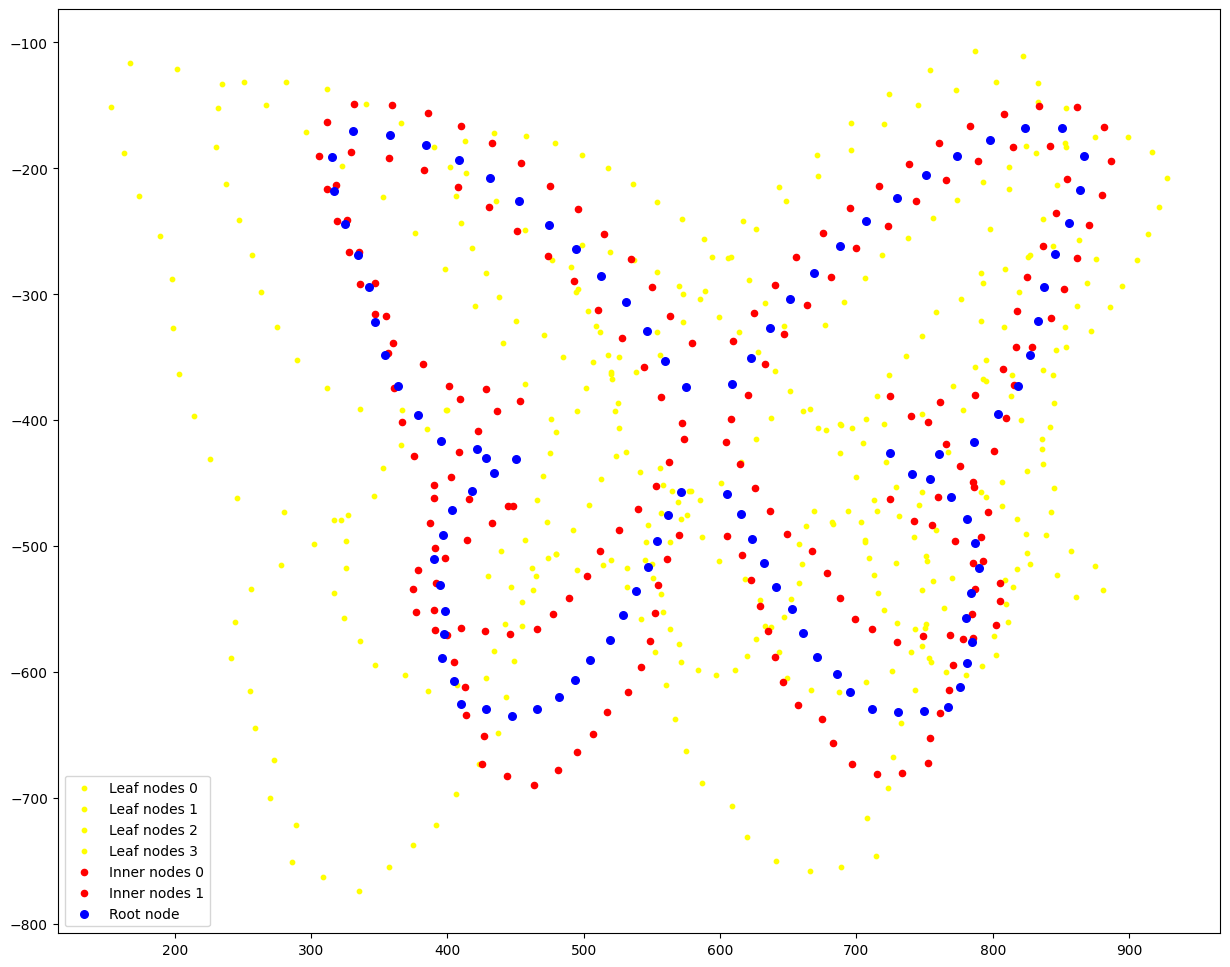

In [14]:
for i,data in enumerate(pre_tree.data['value'][pre_tree.is_leaf]):   
    plt.scatter(data[::2],-data[1::2],color="yellow",s=10, label=f"Leaf nodes {i}")

for i,data in enumerate(pre_tree.data['value'][pre_tree.is_inner]):   
    plt.scatter(data[::2],-data[1::2],color="red",s=20, label=f"Inner nodes {i}")    

plt.scatter(pre_tree.data['value'][0][::2], -pre_tree.data['value'][0][1::2], color='blue',s=30, label="Root node")   
plt.legend()

## Summary
In this notebook, we show how to define a complex operation, a nonlinear weighted shape mean, in _Hyperiax_ and use it for estimating the common ancestor shape of 4 different butterfly species. However, one of the key parameter `sigma` in the LDDMM is assumed to be constant in our case, which is not generally true. In the next notebook, we will see how to use _Hyperiax_ to estimate the parameters using MCMC, and appreciate how fast and easy you can do this.